**<span style="color:crimson;">Metadata**
    
* **Date**: The date a product was purchased
* **Product ID**: The ID for the product
* **Stock Demand**: The quantity of product purchased (unit is in boxes)


# <span style="color:royalblue;">1. Importing libraries and Data

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from glob import glob
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ipywidgets
import inspect
import time
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error

# import pmdarima as pm

In [2]:
# Number of rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# load data
try:
    data.head()
except:
    data = pd.read_excel('pharmaceutical-sales-demand.xlsx')
    
data.head()


,Date,Product ID,Stock Demand
0,2020-10-05,I6DO4,-1
1,2020-10-05,O40SR,16
2,2020-10-19,Y03MS,306
3,2020-10-08,B0OR2,307
4,2020-10-02,EIM03,6


# <span style="color:royalblue;">2. Explore

In [4]:
df = data.copy()
print(f"The shape of the data: {df.shape}\n")
#  data info
df.info()

The shape of the data: (1048575, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1048575 non-null  datetime64[ns]
 1   Product ID    1048575 non-null  object        
 2   Stock Demand  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.0+ MB


In [5]:
# duplicate row
print(f"Duplicate row: {df.duplicated().sum()}\n")

# remove duplication 
df.drop_duplicates(inplace=True)

print(f"New data shape: {df.shape}\n")

Duplicate row: 8916

New data shape: (1039659, 3)



## Columns check

### Stock Demand

In [6]:
# How is stock demand distribution?
df['Stock Demand'].describe([0.05,0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95])

count   1039659.00
mean         80.34
std         612.59
min      -12226.00
5%            1.00
10%           1.00
30%           4.00
50%           9.00
70%          23.00
80%          45.00
90%         124.00
95%         292.00
max      149004.00
Name: Stock Demand, dtype: float64

>  we observe  negatives values for The quantity of product purchased 

> A quantity can not be negative. why do we have negatives values?

> let see the proportion  of negatives values in the data 

In [7]:
neg_values = (sum(df['Stock Demand']<0)/len(df))
print(f'proportion of negative values: {neg_values:.4f}\n')

# we don't have justification for negatives vales and since it's only 
# 0.65 % of the data we assume it's an error and decide to remove them

# Remove negative values
df = df[df['Stock Demand']>=0]

# stock demand distribution without negatives values
df['Stock Demand'].describe([0.05,0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95])

proportion of negative values: 0.0065



count   1032855.00
mean         81.34
std         613.70
min           0.00
5%            1.00
10%           1.00
30%           4.00
50%           9.00
70%          23.00
80%          46.00
90%         125.00
95%         294.00
max      149004.00
Name: Stock Demand, dtype: float64

Text(0.5, 1.0, 'Distribution of Stock Demand')

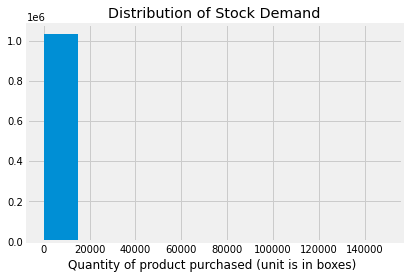

In [8]:
plt.hist(df['Stock Demand'])
plt.xlabel("Quantity of product purchased (unit is in boxes) ")
plt.title("Distribution of Stock Demand")

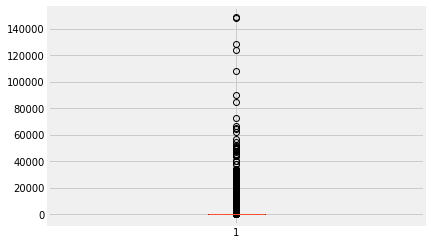

In [9]:
plt.boxplot(df["Stock Demand"]);

>The statistics and the visualisation above confirm what we suspected. 

>While most of the quantity product purchased in our dataset are smaller that 294 boxes, there are some that are several thousand boxes.

>The best thing to do is to remove them from the dataset.

In [10]:
#  remove outlier
# all observations should fall between the 0.05 and 0.95 quantiles for "Stock Demand"

low, high = df["Stock Demand"].quantile([0.05, 0.95])
mask_stock = df["Stock Demand"].between(low, high)
df = df[mask_stock]  

Text(0.5, 1.0, 'Distribution of Stock Demand')

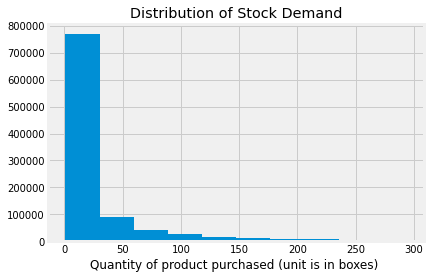

In [11]:
plt.hist(df['Stock Demand'])
plt.xlabel("Quantity of product purchased (unit is in boxes) ")
plt.title("Distribution of Stock Demand")

<AxesSubplot:title={'center':'Distribuion of stock demand'}>

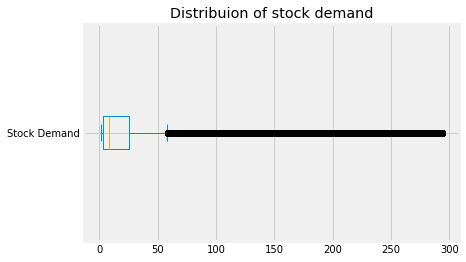

In [12]:
# fig, ax = plt.subplots(figsize=(10, 6))
df["Stock Demand"].plot(kind="box",vert=False, title="Distribuion of stock demand",)

### Product ID

In [13]:
# How many Product are there?
df['Product ID'].nunique()

7781

> High cardinality category feature 

> Let's try identifying useful trends in the data

In [14]:
df['Product ID'].value_counts(normalize=True).mul(100)

N0SI1   0.14
ET0N1   0.12
V0EL1   0.12
1PO0L   0.11
0TR2A   0.11
        ... 
N82T2   0.00
2TN57   0.00
N2T15   0.00
22TNA   0.00
L0A5E   0.00
Name: Product ID, Length: 7781, dtype: float64

>There's no product who was purchased many time more than others 

In [15]:
# Summary Stats for each Product
# 10 first higher quantities purchased

Product = (df.groupby(["Product ID"])
    .agg({"Stock Demand": ["count","sum", "mean", "median", "std", "min", "max"]})
    .sort_values(('Stock Demand','sum'))
          )
 
Product.tail(10) 

Stock Demand                                    
                  count    sum   mean median   std min  max
Product ID                                                 
1PO0L              1103  41976  38.06  19.00 50.72   1  285
1ERV0               585  42126  72.01  59.00 66.79   1  291
CL03I               500  42878  85.76  41.50 90.15   1  294
ER0O1               901  44141  48.99  35.00 52.20   1  291
CE0R1               385  44483 115.54 105.00 90.10   1  294
N0L1A               691  44712  64.71  22.00 73.90   1  288
01AIC               693  46025  66.41  40.00 70.19   1  293
0CL1O               848  47925  56.52  12.00 81.51   1  293
R01SE               775  49512  63.89  18.00 76.36   1  290
R2M0O               571  50125  87.78  58.00 80.89   1  293

> Let's check for trend with the top 100 purchase

In [16]:
@ipywidgets.interact

def Stock(product = Product.tail(100).index):
    df1 = df[df['Product ID']==product]
    # fig, ax = plt.subplots(figsize=(10, 6))
    # sns.scatterplot(x='Date',y='Stock Demand',data=df1,ax=ax)
    fig=px.scatter(df1,x='Date',y='Stock Demand',
                   height=400,width=700)
    return fig

interactive(children=(Dropdown(description='product', options=('T0N3A', 'R20AP', 'P0I2R', 'S0AP1', '0V1IT', 'T…

> we weren't able to find interesting trend and due to the  high cardinality category features we decide to remove `Product ID` from the model


### Date

In [17]:
# date Range
df["Date"].min(), df["Date"].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2021-07-31 00:00:00'))

In [18]:
df['month name'] = df.Date.dt.month_name()
df['month'] = df.Date.dt.month
df['day of month'] = df.Date.dt.day
df['day of year'] = df.Date.dt.dayofyear
df['week of year'] = df.Date.dt.weekofyear
df['day of week'] = df.Date.dt.dayofweek
df['day name'] = df.Date.dt.day_name()
df['year'] = df.Date.dt.year
df["is weekend"] = df.Date.dt.weekday //5
df['is month start'] = df.Date.dt.is_month_start.astype(int)
df['is month end'] = df.Date.dt.is_month_end.astype(int)
df['quarter']= df.Date.dt.quarter

In [19]:
df.sort_values(['Date']).head(10)

,Date,Product ID,Stock Demand,month name,month,day of month,day of year,week of year,day of week,day name,year,is weekend,is month start,is month end,quarter
116052,2020-10-01,5TES9,3,October,10,1,275,40,3,Thursday,2020,0,1,0,4
89843,2020-10-01,7ASF0,1,October,10,1,275,40,3,Thursday,2020,0,1,0,4
89838,2020-10-01,T2I0R,8,October,10,1,275,40,3,Thursday,2020,0,1,0,4
5787,2020-10-01,2R1MT,6,October,10,1,275,40,3,Thursday,2020,0,1,0,4
99324,2020-10-01,0CED2,37,October,10,1,275,40,3,Thursday,2020,0,1,0,4
72842,2020-10-01,AL10C,173,October,10,1,275,40,3,Thursday,2020,0,1,0,4
17484,2020-10-01,0TY1H,9,October,10,1,275,40,3,Thursday,2020,0,1,0,4
55775,2020-10-01,09ETU,2,October,10,1,275,40,3,Thursday,2020,0,1,0,4
102793,2020-10-01,61RI3,14,October,10,1,275,40,3,Thursday,2020,0,1,0,4
55773,2020-10-01,30ASF,5,October,10,1,275,40,3,Thursday,2020,0,1,0,4


In [20]:
@ipywidgets.interact

def Purchased (Time=df.columns[-11:],Stats=["sum","count", "mean", "median",  "min", "max"] ):
    c=[Time] if Time == "year" else [Time,'year']
    df1 = (df.sort_values(['Date']).groupby(c)
            .agg({"Stock Demand": Stats})
          .reset_index())
    df1['year'] = df1['year'].astype(str)
    fig = px.bar(df1, x=Time, y='Stock Demand',color='year',
                 labels={'Stock Demand':f' {Stats.capitalize()} of Stock Demand',
                        Time:Time.capitalize()} ,
                height=400,width=700)
    fig.update_layout(
        title_text=f"<b> {Stats.capitalize()} of Quantity Purchased per {Time.capitalize()}<b>",
        titlefont={'color':'black', 'size': 16, 'family': 'San-Serif'},
        title_x=0.5,
        # template="plotly_dark",
        showlegend=True,
        paper_bgcolor="lightgray",
        plot_bgcolor='lightgray', 
        font=dict(
            color ='black',
        )
    )
    return fig



interactive(children=(Dropdown(description='Time', options=('month', 'day of month', 'day of year', 'week of y…

> what is interesting to notice is that pharmaceutical distribution company has low activity during weekends 

> low activity during July 2021


#  3.Exploring the Data as times series

In [113]:
y = df.groupby('Date')['Stock Demand'].sum()
#This gives us the total quantity purchased on each day.
y

Date
2020-10-01     95022
2020-10-02     98977
2020-10-03      3154
2020-10-04     13250
2020-10-05    128220
               ...  
2021-07-27     47213
2021-07-28     51983
2021-07-29     50101
2021-07-30     44319
2021-07-31     15247
Name: Stock Demand, Length: 304, dtype: int64

In [114]:
# !pip list

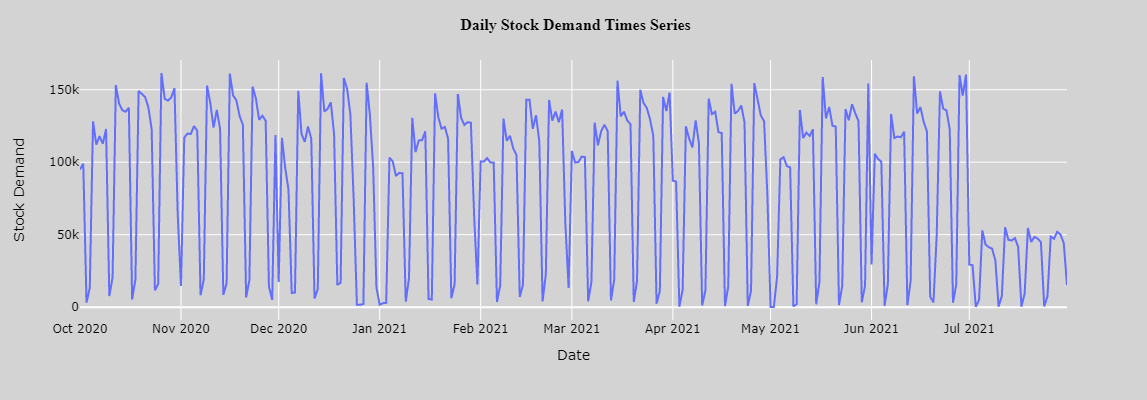

In [115]:
fig = px.line(y , y='Stock Demand',
            height=400,width=1000)
fig.update_layout(
    title_text="<b> Daily Stock Demand Times Series<b>",
    titlefont={'color':'black', 'size': 16, 'family': 'San-Serif'},
    title_x=0.5,
    # template="plotly_dark",
    showlegend=True,
    paper_bgcolor="lightgray",
    plot_bgcolor='lightgray', 
    font=dict(
        color ='black',
    )
)
fig

In [116]:
# y.resample('w').mean().fillna(method='ffill')
y.head(10)

Date
2020-10-01     95022
2020-10-02     98977
2020-10-03      3154
2020-10-04     13250
2020-10-05    128220
2020-10-06    112109
2020-10-07    117941
2020-10-08    112699
2020-10-09    122899
2020-10-10      7683
Name: Stock Demand, dtype: int64

In [117]:
@ipywidgets.interact
#   resemple and mising value
def resampling(Period=['Weekly','Monthly','Semi-Monthly','Quarter'],
               Stats=["sum","mean", "median",  "min", "max"]):
    c = ''.join([a[0] for a in Period.split('-')])
    fig = px.line(y.resample(c).agg({"Stock Demand": Stats}).fillna(method='ffill') , y='Stock Demand',
                height=400,width=800)
    fig.update_layout(
        title_text=f"<b>  {Period} {Stats.capitalize()} of Stock Demand Times Series<b>",
        titlefont={'color':'black', 'size': 16, 'family': 'San-Serif'},
        title_x=0.5,
        # template="plotly_dark",
        showlegend=True,
        paper_bgcolor="lightgray",
        plot_bgcolor='lightgray', 
        font=dict(
            color ='black',
        )
    )
    return fig

interactive(children=(Dropdown(description='Period', options=('Weekly', 'Monthly', 'Semi-Monthly', 'Quarter'),…

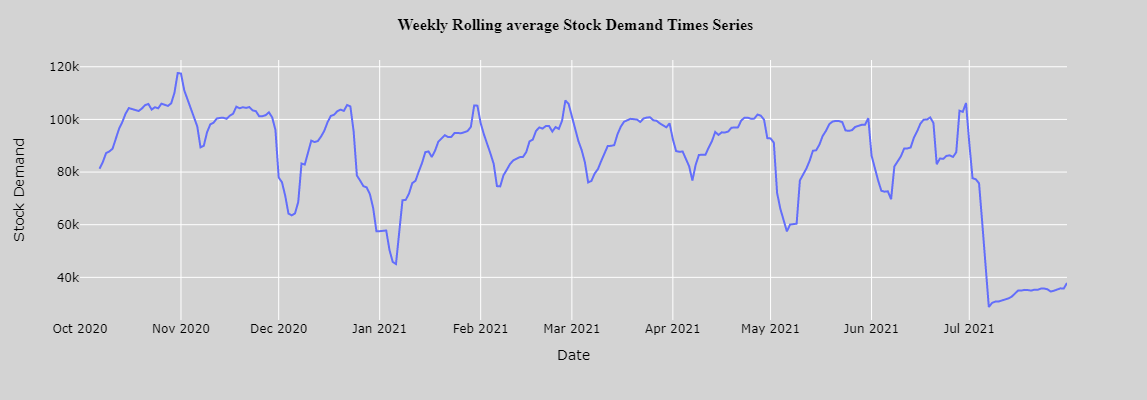

In [118]:


fig = px.line(y.rolling(7).mean().fillna(method='ffill') , y='Stock Demand',
            height=400,width=800)
fig.update_layout(
    title_text="<b> Weekly Rolling average Stock Demand Times Series<b>",
    titlefont={'color':'black', 'size': 16, 'family': 'San-Serif'},
    title_x=0.5,
    # template="plotly_dark",
    showlegend=True,
    paper_bgcolor="lightgray",
    plot_bgcolor='lightgray', 
    font=dict(
        color ='black',
    )
)
fig

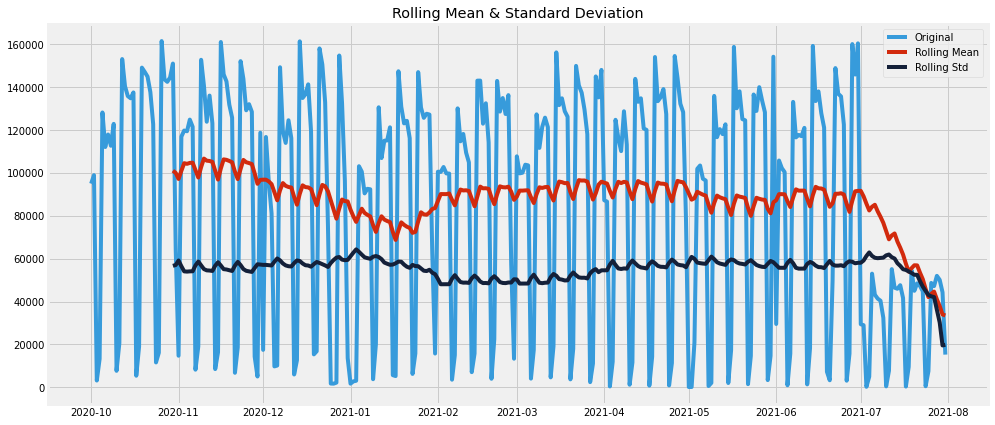

In [119]:
#Determine rolling statistics
y_rolling_avg =y.rolling(window=30).mean() #window size 30 denotes 30 days, giving rolling mean at monthly level
y_rolling_std = y.rolling(window=30).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(y, color='#379BDB', label='Original')
plt.plot(y_rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(y_rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

> There is not general move of upward or general move downward. No really a trend 

> but we can notice some like regular cycle . this is can be explained by sales increase during workdays and decrease during weekends 

>  So some sort of seasonality  in the data

## Augmented Dickey–Fuller Test

In [120]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value',
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(y)

Results of Dickey-Fuller Test:
Test Statistic                 -2.33
p-value                         0.16
#Lags Used                     16.00
Number of Observations Used   287.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


> We can see in the ADF test above that the p-value is 0.16, meaning that it is very likely that the data is not stationary.

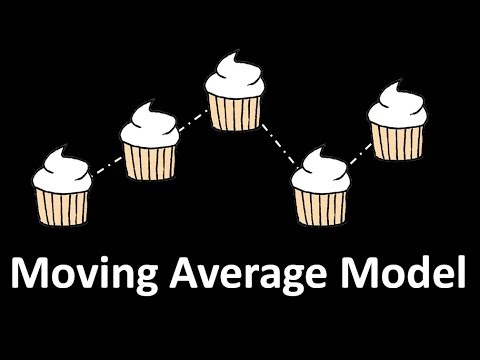

In [121]:
from IPython.display import YouTubeVideo
YouTubeVideo("voryLhxiPzE")

In [122]:
# Check for stationarity
n=9
test_stationarity(y.rolling(window=n).mean().dropna())
print('\n\n diff(1) stationary test')
y1 = pd.Series(np.diff(y))
test_stationarity(y1)

Results of Dickey-Fuller Test:
Test Statistic                 -2.98
p-value                         0.04
#Lags Used                     16.00
Number of Observations Used   279.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


 diff(1) stationary test
Results of Dickey-Fuller Test:
Test Statistic                 -6.52
p-value                         0.00
#Lags Used                     14.00
Number of Observations Used   288.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


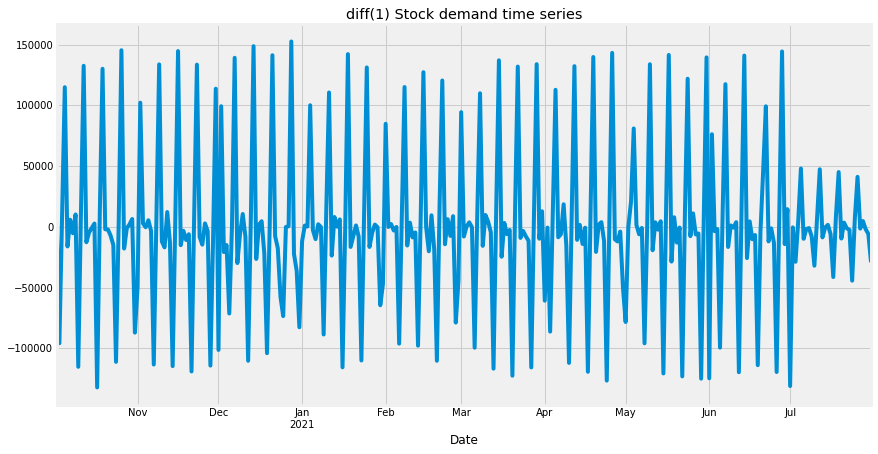

In [123]:
y1.index= y.index[1:]
fig, ax = plt.subplots(figsize=(13, 7))
y1.plot(ax=ax)
plt.title('diff(1) Stock demand time series');

## ACF & PACF

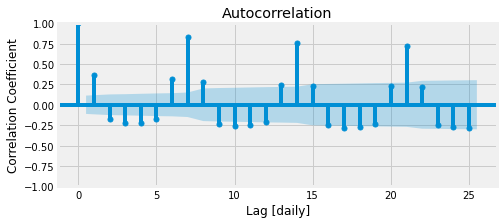

In [124]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(y,ax=ax)
plt.xlabel("Lag [daily]")
plt.ylabel("Correlation Coefficient");

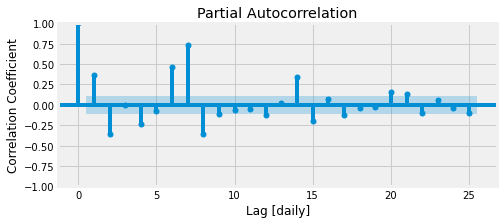

In [125]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [daily]")
plt.ylabel("Correlation Coefficient");

In [126]:
# The first 95% of the data is in the training set.
cutoff_test = int(len(y)*0.90)

# y_train = y[y.index < '2021-06-01']
# y_test = y[y.index>='2021-06-01']

y_train = y[:cutoff_test]
y_test = y[cutoff_test:]

In [127]:
print(y_train.shape)
y_test.shape

(273,)


(31,)

# 4. Build Model


## Baseline

> For the evaluation metric we will use the `mean absolute error` . In statistics, an error is the difference between a measurement and reality. There may not be any difference at all, but there's usually something not quite right, and we need to account for that in our model.

>Absolute error is the error in a single measurement, and mean absolute error is the average error over the course of several measurements.

>The mean absolute error is a common measure of forecast error in time series analysis

In [128]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Stock Demand:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Stock Demand: 90838.2
Baseline MAE: 49459.15


##  Autoregressive

### Iterate

In [136]:
model = AutoReg(y_train, lags=26).fit()

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [138]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:] ,y_pred)
print("Training MAE:", training_mae)

Training MAE: 15845.640779549625


> We was able to beat the baseline mae

In [139]:
y_train_resid = model.resid
y_train_resid.tail()

Date
2021-06-26   -3289.78
2021-06-27    7031.93
2021-06-28   57102.11
2021-06-29   -1176.75
2021-06-30   19334.04
dtype: float64

<AxesSubplot:xlabel='Date', ylabel='residual value'>

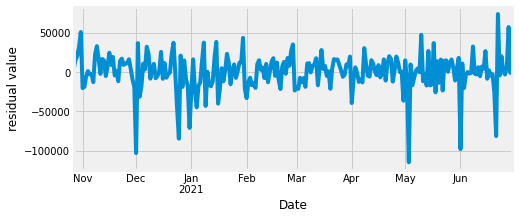

In [140]:
fig, ax = plt.subplots(figsize=(7, 3))
y_train_resid.plot(ylabel="residual value",ax=ax)

Text(0.5, 1.0, 'AR(24) distribution of residual')

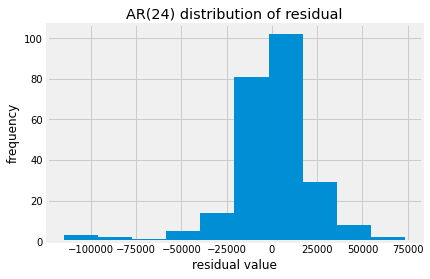

In [141]:
y_train_resid.hist()
plt.xlabel("residual value")
plt.ylabel("frequency")
plt.title("AR(24) distribution of residual")

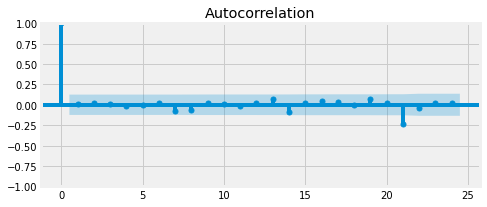

In [142]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(y_train_resid,ax=ax);

> We can notice that the residual are still correlated. mean some exogenous feature have to be add 

### Evaluate

In [143]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 57956.39420027334


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



> Unfortunately The model didn't perform well on the test set

> let see how

In [144]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

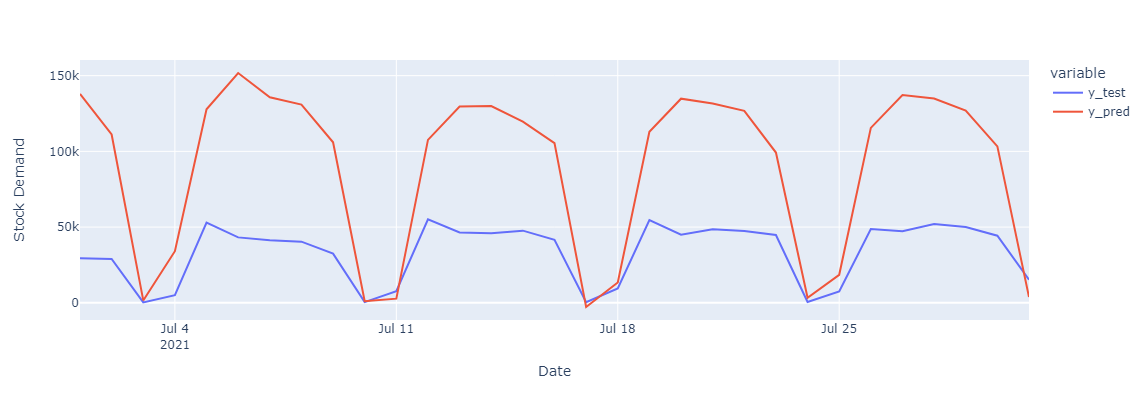

In [145]:
fig = px.line(df_pred_test, labels={"value": "Stock Demand"},
             height=400,width=800)
fig.show()

### Walk forward validation

In [150]:
%%capture

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history,lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [151]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 26444.96


In [152]:
print(model.params)

const              15568.83
Stock Demand.L1        0.47
Stock Demand.L2       -0.07
Stock Demand.L3        0.08
Stock Demand.L4       -0.02
Stock Demand.L5        0.09
Stock Demand.L6        0.08
Stock Demand.L7        0.38
Stock Demand.L8       -0.12
Stock Demand.L9       -0.14
Stock Demand.L10       0.03
Stock Demand.L11       0.03
Stock Demand.L12      -0.01
Stock Demand.L13      -0.18
Stock Demand.L14       0.30
Stock Demand.L15      -0.19
Stock Demand.L16       0.09
Stock Demand.L17      -0.11
Stock Demand.L18       0.01
Stock Demand.L19      -0.05
Stock Demand.L20       0.09
Stock Demand.L21       0.18
Stock Demand.L22      -0.11
Stock Demand.L23       0.07
Stock Demand.L24       0.01
Stock Demand.L25      -0.04
Stock Demand.L26      -0.05
dtype: float64


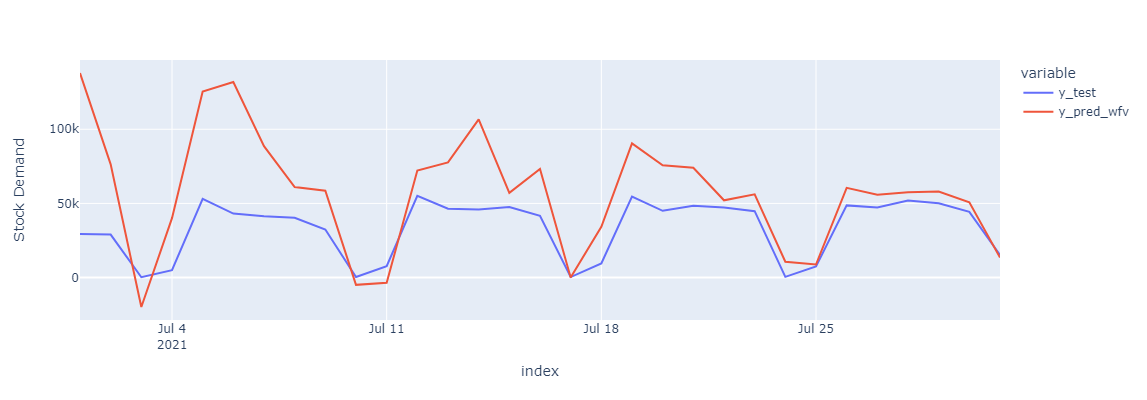

In [153]:
df_pred_test = pd.DataFrame(
    {"y_test":y_test, "y_pred_wfv":y_pred_wfv}
)
fig = px.line(df_pred_test, labels={"value":"Stock Demand"},
             height=400,width=800)
fig.show()

## ARIMA

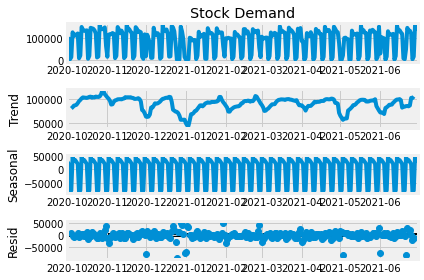

In [154]:


decomposition = sm.tsa.seasonal_decompose(y_train, model='additive')
fig = decomposition.plot()

In [156]:
p_params = range(0,25,6)
q_params = range(3)

In [157]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 1, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (0, 1, 0) in 0.48 seconds.
Trained ARIMA (0, 1, 1) in 0.16 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred fr

Trained ARIMA (0, 1, 2) in 0.26 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (6, 1, 0) in 0.37 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization fail

Trained ARIMA (6, 1, 1) in 0.95 seconds.
Trained ARIMA (6, 1, 2) in 1.12 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (12, 1, 0) in 1.27 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization fail

Trained ARIMA (12, 1, 1) in 1.88 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (12, 1, 2) in 1.84 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Us

Trained ARIMA (18, 1, 0) in 4.43 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (18, 1, 1) in 4.07 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Trained ARIMA (18, 1, 2) in 3.77 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 1, 0) in 6.47 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization fail

Trained ARIMA (24, 1, 1) in 5.85 seconds.


C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 1, 2) in 6.64 seconds.

{0: [42059.16117216117, 50463.26712803513, 39271.42749907865], 6: [20171.504567995387, 19451.430375249067, 18981.00512669634], 12: [18672.122059162164, 18372.497532021924, 18545.825697826775], 18: [17475.91895170069, 17619.494630716155, 17410.25033923952], 24: [17266.01235270093, 17146.118809954325, 17140.11730126023]}


In [158]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,6,12,18,24
0,42059.16,20171.50,18672.12,17475.92,17266.01
1,50463.27,19451.43,18372.50,17619.49,17146.12
2,39271.43,18981.01,18545.83,17410.25,17140.12


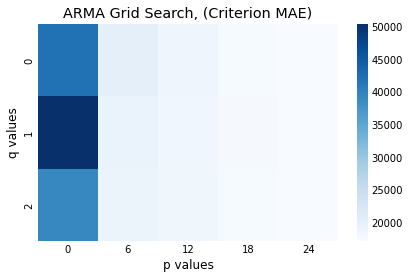

In [159]:
sns.heatmap(mae_df,cmap='Blues')
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search, (Criterion MAE)');

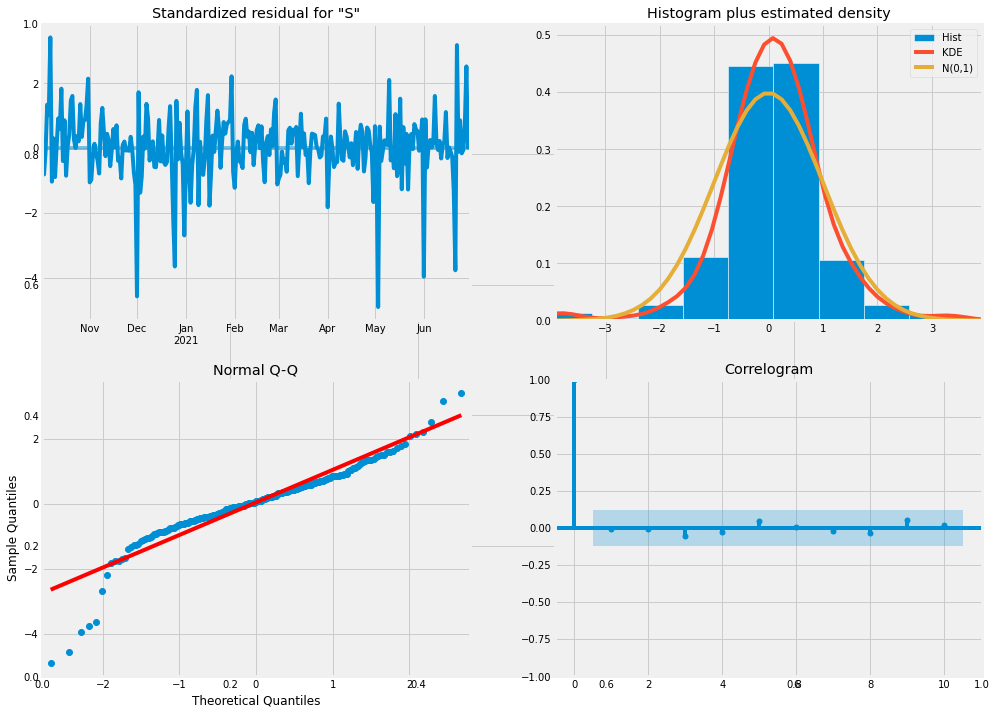

In [160]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

In [164]:
model = ARIMA(y_train,order=(24,1,2)).fit()

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [182]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 18968.7315066102


> The arima model perform well with the test set

In [173]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

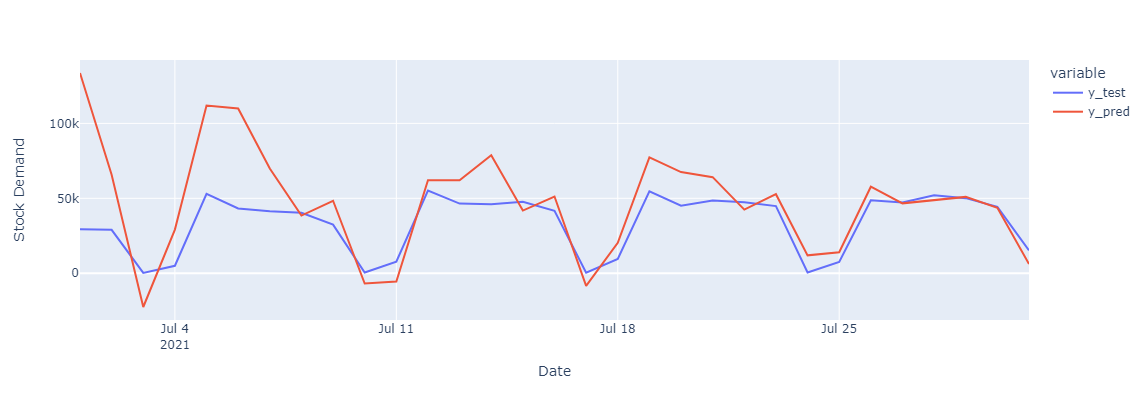

In [174]:
fig = px.line(df_pred_test, labels={"value": "Stock Demand"},
             height=400,width=800)
fig.show()

In [175]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history,order=(24,1,2)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D

In [176]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 23723.19


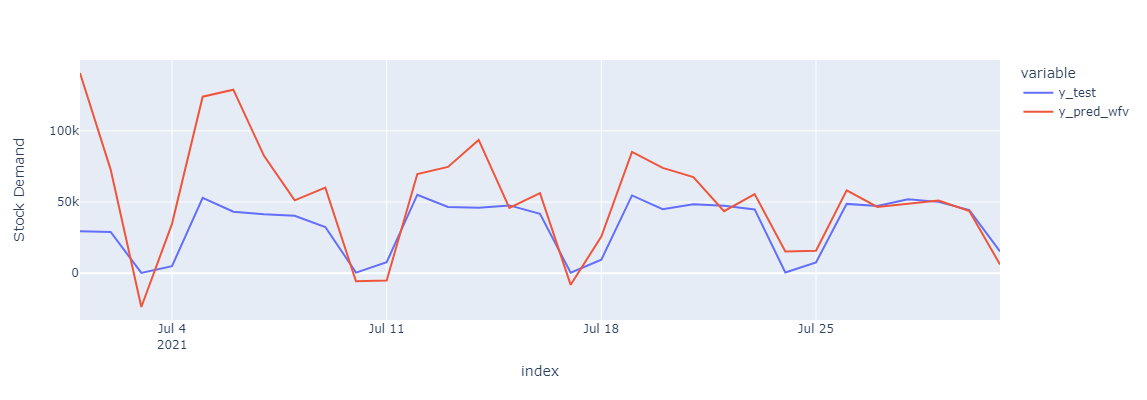

In [177]:
df_predictions = pd.DataFrame(
    {"y_test":y_test, "y_pred_wfv":y_pred_wfv}
)

fig = px.line(df_predictions,labels={"value":"Stock Demand"},height=400,width=800)
fig.show()

In [178]:
model = ARIMA(y,order=(24,1,2)).fit()

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Abdel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [179]:
y_predict = model.predict('2021-08-01', '2021-08-31')


In [180]:
y_predict

2021-08-01   15985.96
2021-08-02   54998.87
2021-08-03   49452.74
2021-08-04   51084.37
2021-08-05   50334.79
2021-08-06   45814.15
2021-08-07   11899.68
2021-08-08   17692.67
2021-08-09   52295.98
2021-08-10   47840.69
2021-08-11   49621.63
2021-08-12   49764.18
2021-08-13   43892.55
2021-08-14   12047.87
2021-08-15   15890.35
2021-08-16   50500.20
2021-08-17   46363.60
2021-08-18   47593.99
2021-08-19   47471.15
2021-08-20   42832.50
2021-08-21   12983.30
2021-08-22   17242.54
2021-08-23   50363.42
2021-08-24   46566.88
2021-08-25   46942.21
2021-08-26   47840.67
2021-08-27   43038.76
2021-08-28   14573.54
2021-08-29   19083.52
2021-08-30   50196.47
2021-08-31   46783.79
Freq: D, Name: predicted_mean, dtype: float64

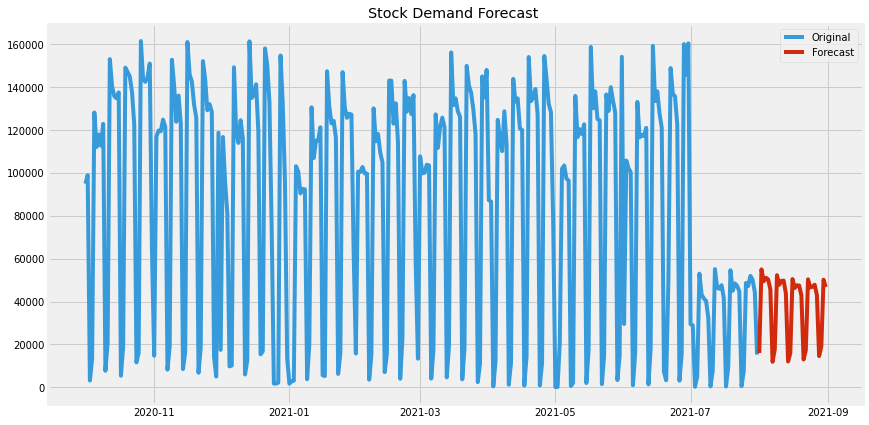

In [184]:
plt.figure(figsize=(13,7))
plt.plot(y, color='#379BDB', label='Original')
plt.plot(y_predict, color='#D22A0D', label='Forecast')
plt.legend(loc='best')
plt.title('Stock Demand Forecast ')
plt.show(block=False)